Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print statinfo.st_size
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        for name in f.namelist():
            return tf.compat.as_str(f.read(name)).split()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
print words[:100]

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def char_range(c1, c2):    
    for c in xrange(ord(c1), ord(c2)+1):
        yield chr(c)

def denoise(words):
    with open('en.noise.dict', 'r') as f:
        noise = [ln.strip() for ln in f]
    noise = noise + [x for x in char_range('a', 'z')]
    print noise
    #o(n^2)
    return filter(lambda v: v not in noise, words)    

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#denoise
#print len(words)
#words = denoise(words)
#print 'and after denoise: %i' % len(words)
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156])


In [6]:
dictionary[5239]

KeyError: 5239

Function to generate a training batch for the skip-gram model.

In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

def generate_batch_cbow(batch_size, window_size):
    global data_index
    #assert batch_size % (2*window_size) == 0
    batch = np.ndarray(shape=(batch_size, 2 * window_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    if data_index < window_size:
        data_index = window_size #avoid negative indexes
    for i in range(batch_size): #/ (2*window_size)
        for j in range(-window_size, window_size+1):
            if j != 0:
                train_idx = (data_index + j) % len(data)
                batch[i, window_size + (j if j < 0 else j-1)]  = data[train_idx]
        labels[i] = data[data_index]
        data_index = (data_index + 1) % len(data)
        if data_index < window_size:
            data_index = window_size #avoid negative indexes
    
    return batch, labels

def test_batch():
    #print data_index
    
    batch, labels = generate_batch_cbow(batch_size=8, window_size=2)
    print labels
    #print data_index
    for i in range(8):
      print('%s -> %d' % (batch[i], labels[i, 0]))
      print('%s -> %s' % ([reverse_dictionary[idx] for idx in batch[i]],
                          reverse_dictionary[labels[i, 0]]))

    print batch, labels, data[:16]

#batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
print len(data)
test_batch()
test_batch()
#test wrap
data_index = len(data) - 1
test_batch()

17005207
[[  12]
 [   6]
 [ 195]
 [   2]
 [3137]
 [  46]
 [  59]
 [ 156]]
[5239 3084    6  195] -> 12
['anarchism', 'originated', 'a', 'term'] -> as
[3084   12  195    2] -> 6
['originated', 'as', 'term', 'of'] -> a
[  12    6    2 3137] -> 195
['as', 'a', 'of', 'abuse'] -> term
[   6  195 3137   46] -> 2
['a', 'term', 'abuse', 'first'] -> of
[195   2  46  59] -> 3137
['term', 'of', 'first', 'used'] -> abuse
[   2 3137   59  156] -> 46
['of', 'abuse', 'used', 'against'] -> first
[3137   46  156  128] -> 59
['abuse', 'first', 'against', 'early'] -> used
[ 46  59 128 742] -> 156
['first', 'used', 'early', 'working'] -> against
[[5239 3084    6  195]
 [3084   12  195    2]
 [  12    6    2 3137]
 [   6  195 3137   46]
 [ 195    2   46   59]
 [   2 3137   59  156]
 [3137   46  156  128]
 [  46   59  128  742]] [[  12]
 [   6]
 [ 195]
 [   2]
 [3137]
 [  46]
 [  59]
 [ 156]] [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1]
[[  128]
 [  742]
 [  477]
 [10572]
 [  

Train a skip-gram model.

In [72]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                 stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(0.2).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #||embeddings|| = sqrt(sum(ei^2))
    normalized_embeddings = embeddings / norm #normalize vector so ||embeddings|| = 1
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) #both vectors len==1 so just dot product

In [125]:
def train(num_steps, batch_generator):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = batch_generator()
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
              if step > 0:
                average_loss = average_loss / 2000
              # The average loss is an estimate of the loss over the last 2000 batches.
              print('Average loss at step %d: %f' % (step, average_loss))
              average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
              #print batch_data
              #print batch_labels
              #emb_flat = embed_flat.eval({train_dataset : batch_data, train_labels : batch_labels})
              #print emb_flat.shape
              #print emb_flat
              #emb_stacked = embed_stacked.eval({train_dataset : batch_data, train_labels : batch_labels})
              #print emb_stacked.shape
              #print emb_stacked
              #emb = embed.eval({train_dataset : batch_data, train_labels : batch_labels})
              #print emb.shape
              #print emb
              sim = similarity.eval()
              for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                  close_word = reverse_dictionary[nearest[k]]
                  log = '%s %s,' % (log, close_word)
                print(log)
        return normalized_embeddings.eval()

In [99]:
num_steps = 100001
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

from functools import partial

gen_skipgram = partial(generate_batch, batch_size, num_skips, skip_window)
final_embeddings = train(10001, gen_skipgram)

Initialized


ValueError: Cannot feed value of shape (128,) for Tensor u'Placeholder:0', which has shape (Dimension(None), Dimension(8))

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [140]:
embedding_size = 128 # Dimension of the embedding vector.
window_size = 2
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[None, 2*window_size])
    train_labels = tf.placeholder(tf.int32, shape=[None, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                 stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    #embed = tf.Variable(tf.zeros([None, embedding_size]))

    # Model.
    # Look up embeddings for inputs.
    embed_flat = tf.nn.embedding_lookup(embeddings, tf.reshape(train_dataset, [-1])) #flatten and do lookup
    embed_stacked = tf.reshape(embed_flat, [-1, 2*window_size, embedding_size]) #back windows_size groups of batch_size embeddings
    embed = tf.reduce_mean(embed_stacked,1) #reduce across windows_size -> back to batch_size embeddings
    #embed = tf.div(embed, 8) #go back to initial vector magnitude
    #for i in range(4):
    #    if i == 0:
    #        embed = tf.nn.embedding_lookup(embeddings, train_dataset[:, i])
    #    else:
    #        embed = tf.reduce_sum()
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #||embeddings|| = sqrt(sum(ei^2))
    normalized_embeddings = embeddings / norm #normalize vector so ||embeddings|| = 1
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) 

In [141]:
from functools import partial

gen_cbow = partial(generate_batch_cbow, 128, window_size)
final_embeddings = train(1000001, gen_cbow)

Initialized
Average loss at step 0: 7.403265
Nearest to from: flatland, rustic, lately, kahan, paranthropus, orientational, aldermen, hiller,
Nearest to b: substantiated, yahweh, aardvarks, analgesic, lb, blasphemy, casa, tejada,
Nearest to about: fossilization, polemics, fifa, inscribed, guideline, bomarc, venice, clytemnestra,
Nearest to were: inflectional, nederlandse, monoxide, stonework, vba, reassigned, swat, near,
Nearest to some: kuan, testable, phone, federative, bristles, olmec, moctezuma, clinician,
Nearest to these: jon, fraction, characterizes, embarking, chile, transported, kenjutsu, syndicated,
Nearest to at: colourful, rinzai, gypsys, revolutionized, formants, anew, mallarm, ingolstadt,
Nearest to of: eocene, lumberjack, donelson, secluded, rouse, oas, gentle, stalingrad,
Nearest to would: afterthought, hal, marbury, huntingdon, impairments, toulouse, harnack, oliphant,
Nearest to for: unaffected, strong, distress, loosened, greenaway, oppression, pains, asians,
Nearest

In [142]:
num_points = 14000

tsne = TSNE(perplexity=30, n_components=2, init='pca', early_exaggeration = 15, n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

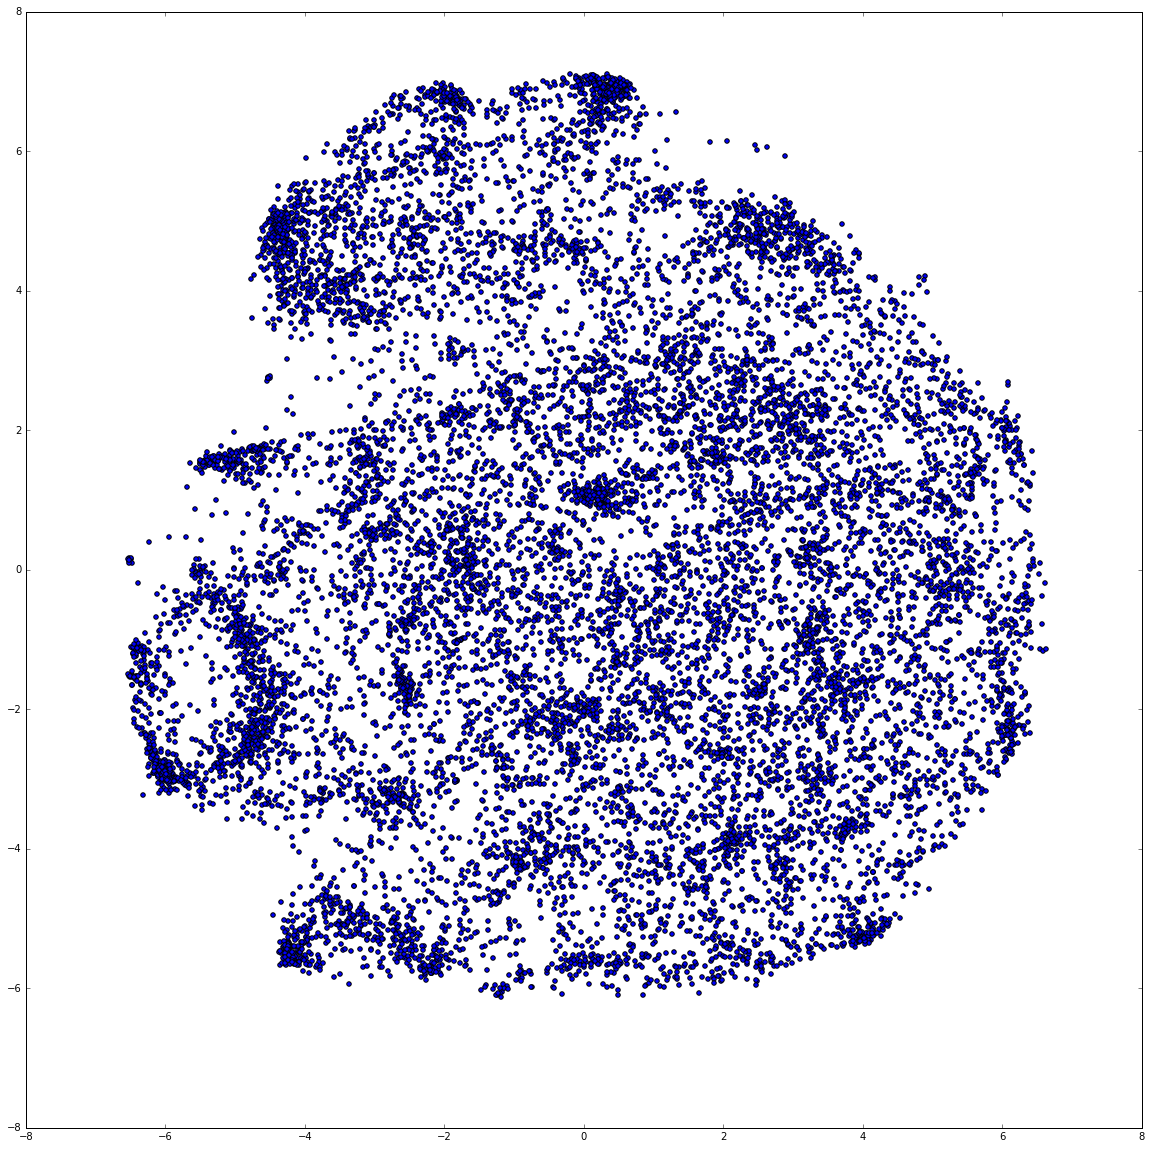

In [143]:
%matplotlib inline
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    #pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
    #               ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)